# Global Economic Incentive Routing
## Online Learning Model
### Prepared by BlockScience for Status

#### The goal of this notebook is to demonstrate the mechanism used to incentivize faster routing in the Status economic model. 

In [1]:
from decimal import Decimal
import numpy as np
import pandas as pd
from datetime import timedelta
import requests
import json
import datetime
from scipy import stats
from scipy.stats import gamma
from scipy.stats import powerlaw
import scipy.stats as stats
from scipy.odr import *
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn import linear_model

from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=50)
from matplotlib import cm
import matplotlib.ticker as ticker

sns.set_style("whitegrid")

Given a set of solved routes, with two dimensions, distance and time.
Specifically, the distance is the routing distance from stored file to recipient and the time is time from request initiation to publishing proof of receipt.

In [2]:
# Uncorrelated random
dist = 10 * np.random.rand(100,1)
time = 5 * np.random.rand(100,1)

# Correlated random, time dependent on independent distance
dist = 10 * np.random.rand(100)
time = dist * np.random.rand(100)

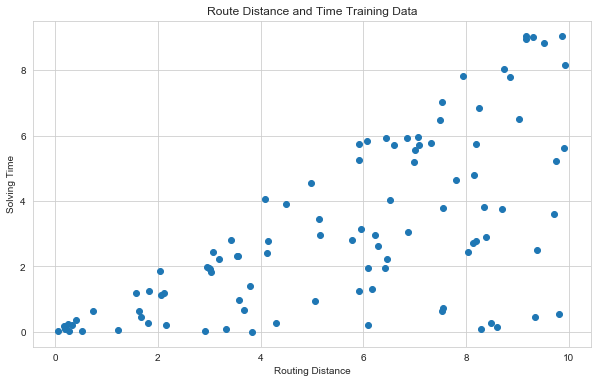

In [3]:
plt.figure(figsize=(10,6))
plt.scatter(dist, time)
plt.xlabel('Routing Distance')
plt.ylabel('Solving Time')
plt.title('Route Distance and Time Training Data')
dir_name = 'images/'
file_name = 'training'
plt.savefig(dir_name+file_name)
plt.show()

Linear Regression of Sample data

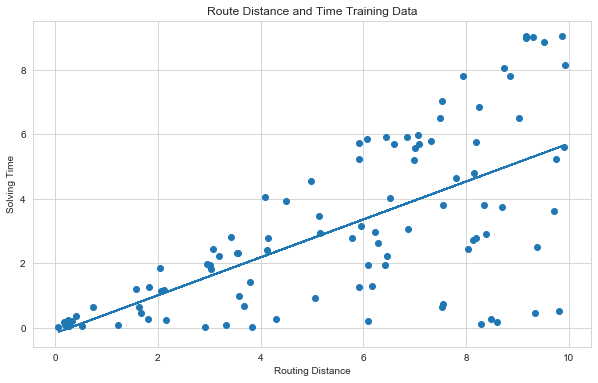

In [4]:
slope, intercept, r_value, p_value, std_err = stats.linregress(dist, time)

plt.figure(figsize=(10,6))
plt.scatter(dist, time)
plt.plot(dist, slope*dist + intercept)
plt.xlabel('Routing Distance')
plt.ylabel('Solving Time')
plt.title('Route Distance and Time Training Data')
dir_name = 'images/'
file_name = 'lin_regress'
plt.savefig(dir_name+file_name)
plt.show()

## Coordinate Transformation
Distance-Time Problem transformed from rectangular to polar coordinates.

Magnitude of the distance-time problem:

$ r = \sqrt{Dist^2 + Time^2}$

Angle between Distance and Time describes the expected 'skew' toward time:

$ \theta = \tan^{-1}(\frac{Time}{Dist})$

In [5]:
def cart_to_pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(r, theta)

def pol_to_cart(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return(x, y)

def speed(dist,time):
    speed = dist/time
    theta = np.arctan2(1,speed)
    return theta

In [6]:
radii, angles = cart_to_pol(dist,time)

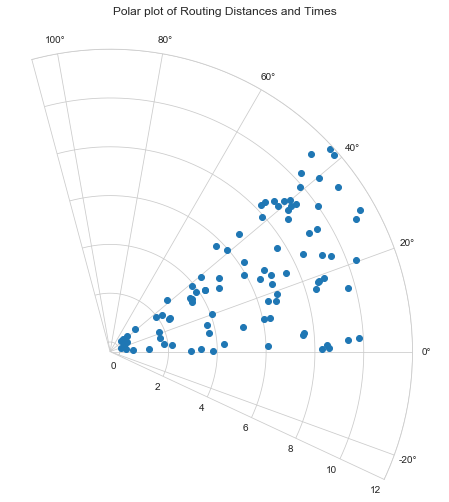

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.subplot(111, projection='polar')
ax.scatter(angles, radii)
ax.set_rmax(12)
ax.set_rticks([0, 2,4,6,8,10,12])  # less radial ticks
ax.set_rlabel_position(60)  # get radial labels away from plotted line

ax.set_thetamin(-25)
ax.set_thetamax(105)

ax.grid(True)

ax.set_title("Polar plot of Routing Distances and Times", va='bottom')
dir_name = 'images/'
file_name = 'polar_trans'
plt.savefig(dir_name+file_name)
plt.show()

The angle is a calculation of the difference between routing distance and solving time. The coordinate transformation reduces the routing problem solving time to one dimension.

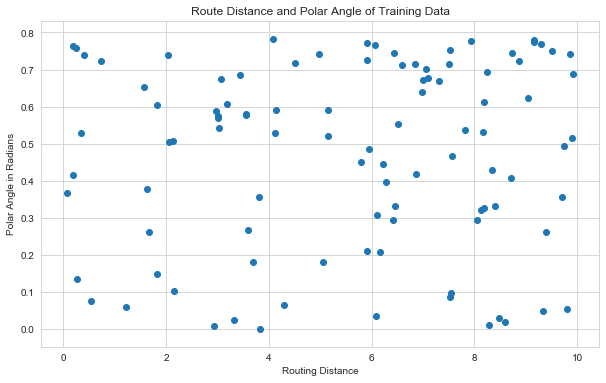

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(dist, angles)
plt.xlabel('Routing Distance')
plt.ylabel('Polar Angle in Radians')
plt.title('Route Distance and Polar Angle of Training Data')
dir_name = 'images/'
file_name = 'angle_route'
plt.savefig(dir_name+file_name)
plt.show()

Introduce new route

In [9]:
dist_new = 10 * np.random.rand()
time_new = dist_new * np.random.rand()

Calculate new angle of new route

In [10]:
radius_new, angle_new = cart_to_pol(dist_new, time_new)

Calculate the z-score of the angles and view the distribution

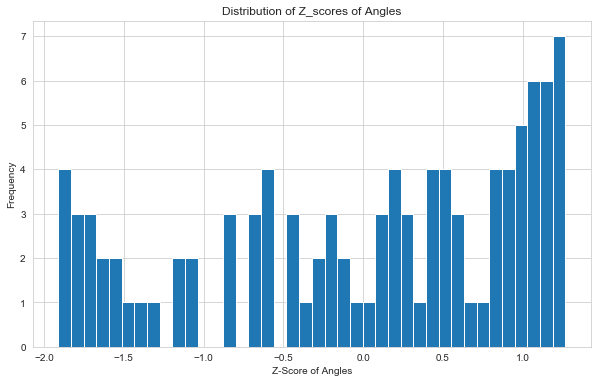

In [11]:
zees = stats.zscore(angles)

plt.figure(figsize=(10,6))
plt.hist(zees, bins = 40)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Distribution of Z_scores of Angles')
dir_name = 'images/'
file_name = 'angle_route'
plt.savefig(dir_name+file_name)
plt.show()

In [12]:
df = pd.DataFrame(zees, columns = ['zees'])
df['angles'] = angles

df.sort_values(by=['angles'], inplace =True)

In [13]:
actual_zee = np.interp(angle_new, df.angles, df.zees)
actual_zee

0.5852072878588318

New Route in the set of angles

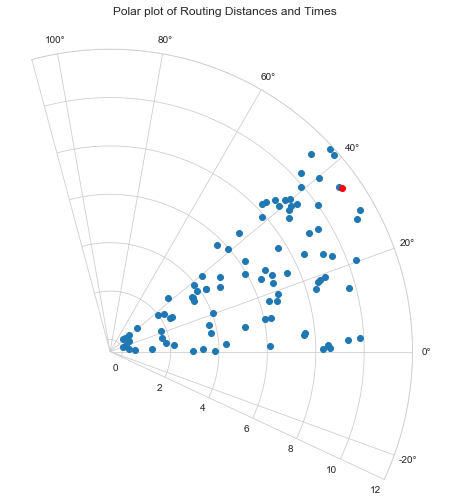

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.subplot(111, projection='polar')
ax.scatter(angles, radii)
ax.scatter( angle_new,radius_new,color='r')
ax.set_rmax(12)
ax.set_rticks([0, 2,4,6,8,10,12])  # less radial ticks
ax.set_rlabel_position(60)  # get radial labels away from plotted line

ax.set_thetamin(-25)
ax.set_thetamax(105)

ax.grid(True)

ax.set_title("Polar plot of Routing Distances and Times", va='bottom')
dir_name = 'images/'
file_name = 'polar_with_new_point'
plt.savefig(dir_name+file_name)
plt.show()

Inlcude new solved route into angles and compute new set of z_scores for all routes

In [15]:
angles_appended = np.append(angles, angle_new)

zees_appended = stats.zscore(angles_appended)

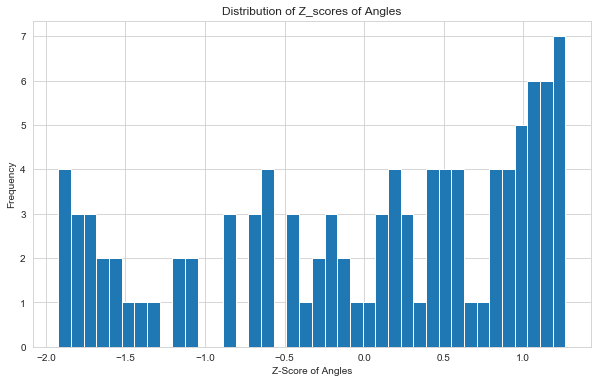

In [16]:
plt.figure(figsize=(10,6))
plt.hist(zees_appended, bins = 40)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Distribution of Z_scores of Angles')
dir_name = 'images/'
file_name = 'angle_route'
plt.savefig(dir_name+file_name)
plt.show()

Get expected z_score of the route posterior to providing the information

In [17]:
exp_zee = zees_appended[-1]

In [18]:
exp_zee

0.581318291701727

In [19]:
diff =  ( actual_zee - exp_zee )
diff

0.003888996157104807

In [20]:
def incentive(diff):
    if diff > 0:
#         tax = np.array(params['tax_%'], dtype = float) * diff * np.array(escrow, dtype = float)
        tax = diff
        subsidy = 0
    else:
#         subsidy_from_treasury = np.array(params['subsidy_treasury'], dtype = float) * diff * prev_state['treasury']
#         subsidy_from_escrow = np.array(params['subsidy_escrow'], dtype = float) * diff * np.array(escrow, dtype = float)
#         subsidy = min(subsidy_from_treasury, subsidy_from_escrow)
        subsidy = diff
        tax = 0
    return tax, subsidy

In [21]:
tax, subsidy = incentive(diff)
print('tax = ',tax, ' subsidy = ',subsidy)

tax =  0.003888996157104807  subsidy =  0


In [22]:
df_app = pd.DataFrame(zees_appended, columns = ['zees'])
df_app['angles'] = angles_appended

df_app.sort_values(by=['angles'], inplace =True)

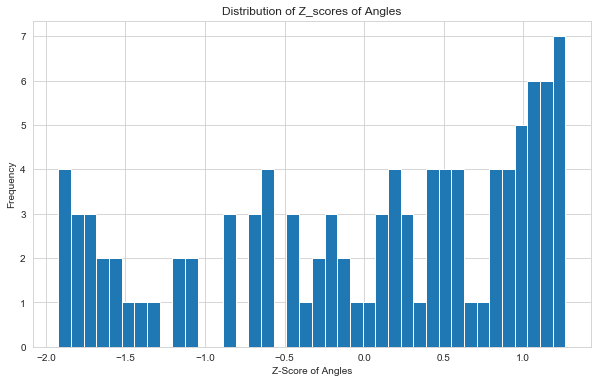

In [23]:
plt.figure(figsize=(10,6))
plt.hist(df_app.zees,  bins = 40)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Distribution of Z_scores of Angles')
dir_name = 'images/'
file_name = 'angle_route'
plt.savefig(dir_name+file_name)
plt.show()

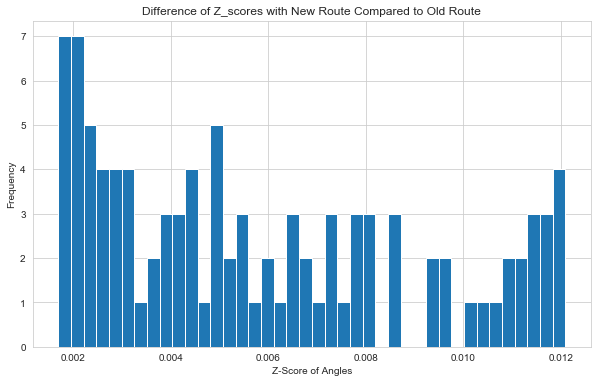

In [25]:
plt.figure(figsize=(10,6))
if diff > 0:
    plt.hist(df.zees - df_app.zees[0:len(df.zees)], bins = 40)
else:
    plt.hist(df_app.zees[0:len(df.zees)] - df.zees, bins = 40)

plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Difference of Z_scores with New Route Compared to Old Route')
dir_name = 'images/'
file_name = 'angle_route'
plt.savefig(dir_name+file_name)
plt.show()